In [ ]:
!pip install pytorch-msssim

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from pytorch_msssim import ssim
import math
import pickle

In [ ]:
def get_coord_grid(H, W):
    """
    Returns a tensor of shape (H*W, 2) with normalized (x, y) coordinates
    in the range [-1, 1].
    """
    y = torch.linspace(-1, 1, steps=H)
    x = torch.linspace(-1, 1, steps=W)
    yy, xx = torch.meshgrid(y, x, indexing="ij")
    coords = torch.stack([xx, yy], dim=-1)  # (H, W, 2)
    coords = coords.reshape(-1, 2)          # (H*W, 2)
    return coords

# MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),  # (H,W) in [0,1]
])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

# Define target image
H, W = 28, 28
coords = get_coord_grid(H, W)

In [ ]:
# --------------------------
# RuleNet
# --------------------------
class RuleNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim

    def forward(self, x, weights):
        """
        coords: (B, N, 2)
        weights: list of [W1, b1, W2, b2, W3, b3]
        """
        W1, b1, W2, b2, W3, b3 = weights

        h1 = torch.bmm(x, W1.transpose(1,2)) + b1
        h1 = torch.sin(h1)

        # Layer 2: (B, N, 16)
        h2 = torch.bmm(h1, W2.transpose(1,2)) + b2
        h2 = torch.sin(h2)

        # Layer 3: (B, N, 1)
        out = torch.bmm(h2, W3.transpose(1,2)) + b3
        out = torch.sigmoid(out)
        return out  # (B, N, 1)


# --------------------------
# HyperNet (VAE)
# --------------------------
class HyperNetVAE(nn.Module):
    def __init__(self, img_dim=28*28, hidden_dim=256, latent_dim=64, rule_dims=[(8,16),(16,16),(16,1)]):
        super().__init__()
        self.img_dim = img_dim
        self.latent_dim = latent_dim
        self.rule_dims = rule_dims

        # Encoder
        self.C1 = nn.Conv2d(1, 16, 4, 2, 1)
        self.C_mu = nn.Conv2d(16, latent_dim, 4, 2, 1)
        self.C_logvar = nn.Conv2d(16, latent_dim, 4, 2, 1)

        # Decoder (maps z → all RuleNet weights flattened)
        total_weights = sum(in_d*out_d + out_d for in_d, out_d in rule_dims)
        self.dec_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, total_weights)

    def encode(self, x):
        h = torch.relu(self.C1(x))
        mu = self.C_mu(h).sum(dim=(2, 3))
        logvar = self.C_logvar(h).sum(dim=(2, 3))
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.dec_fc1(z))
        flat_weights = self.dec_fc2(h)

        # Split into RuleNet weight matrices/biases
        weights = []
        idx = 0
        for in_d, out_d in self.rule_dims:
            W_size = in_d * out_d
            b_size = out_d

            W = flat_weights[:, idx:idx+W_size].view(-1, out_d, in_d)
            idx += W_size
            b = flat_weights[:, idx:idx+b_size].view(-1, 1, out_d)
            idx += b_size

            weights.extend([W.squeeze(0), b.squeeze(0)])

        return weights

    def forward(self, imgs):
        """
        imgs: (batch, 1, 28, 28)
        """
        mu, logvar = self.encode(imgs)
        z = self.reparameterize(mu, logvar)
        weights = self.decode(z)
        return weights, mu, logvar


# --------------------------
# Training Loop (sketch)
# --------------------------
def vae_loss(recon_img, orig_img, mu, logvar):
    recon_loss = F.mse_loss(recon_img, orig_img, reduction="sum") + (1 - ssim(recon_img, orig_img, data_range=1, size_average=True))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

Epoch: 0/5 Iteration 0 Loss:325765.2188


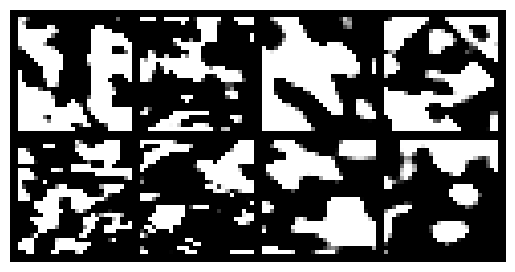

Epoch: 0/5 Iteration 1000 Loss:723.3484


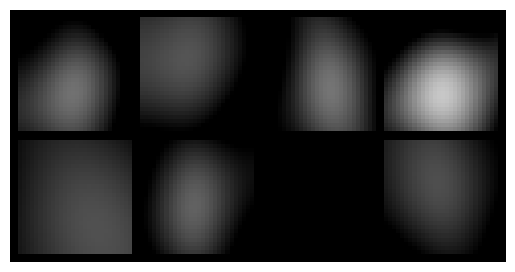

Epoch: 0/5 Iteration 2000 Loss:556.3368


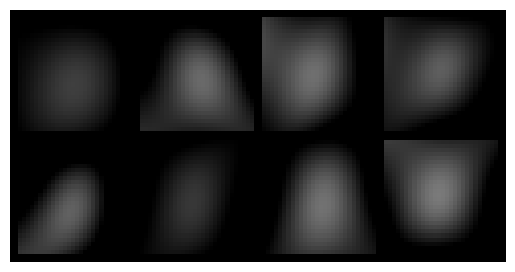

Epoch: 0/5 Iteration 3000 Loss:527.2596


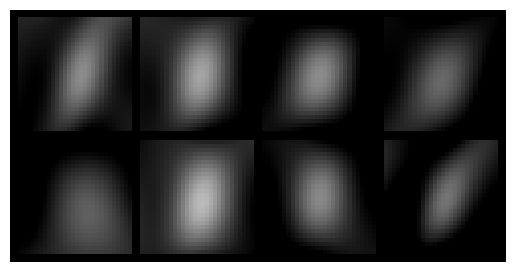

Epoch: 0/5 Iteration 4000 Loss:513.2662


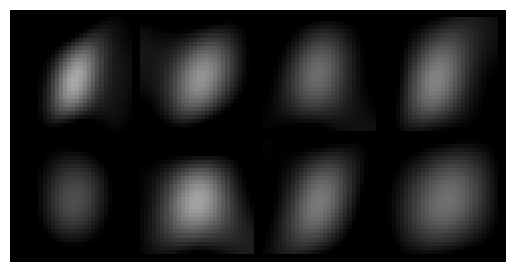

In [ ]:
hypernet = HyperNetVAE()
rulenet = RuleNet()

optimizer = torch.optim.Adam(hypernet.parameters(), lr=1e-3)
epochs = 5

B = torch.randn(4, 2)
x_proj = 2 * torch.pi * coords @ B.T
x_proj = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

for epoch in range(epochs):
    for k, (imgs, _) in enumerate(train_loader):
        # Flatten images for encoder
        # HyperNet → weights
        weights, mu, logvar = hypernet(imgs)
        #coords_ = coords.view(1, -1, 2).repeat(imgs.shape[0], 1, 1)
        x_proj_ = x_proj.view(1, 784, 8).repeat(imgs.shape[0], 1, 1)

        # RuleNet forward
        recon_flat = rulenet(x_proj_, weights)  # (batch, N, 1)
        recon_img = recon_flat.view(-1, 1, 28, 28)

        loss = vae_loss(recon_img, imgs, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if k % 1000 == 0:
          print(f"Epoch: {epoch}/{epochs} Iteration {k} Loss:{round(loss.item(), 4)}")

          grid = make_grid(recon_img, nrow=4)
          grid = grid.numpy().transpose(1, 2, 0)
          plt.imshow(grid)
          plt.axis('off')
          plt.show()